# EDA and Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import psycopg2 as pg2
from sqlalchemy import create_engine

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import pairwise_distances

sns.set_style('darkgrid')
sns.set_palette(palette='colorblind')
%matplotlib inline

In [2]:
%run ../bx_sql.py

In [3]:
engine = create_engine(f'postgres://{USER}:{PASSWORD}@{FULL_IP_ADDRESS}:5432/{DBNAME}')

## Retrieve Data from PostgreSQL Database

### Books

In [4]:
books_df = pd.read_sql_table('books', engine)

books_df.head()

,isbn,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l
0,8440616252,El paraÃ­so (Tiempos modernos),Elena Castedo,1991,"Editiones B, Grupo Zeta",http://images.amazon.com/images/P/8440616252.0...,http://images.amazon.com/images/P/8440616252.0...,http://images.amazon.com/images/P/8440616252.0...
1,8472224260,Negra i consentida (ColÂ¨lecciÃ³ El Mirall),OfÃ¨lia Dracs,1983,Laia,http://images.amazon.com/images/P/8472224260.0...,http://images.amazon.com/images/P/8472224260.0...,http://images.amazon.com/images/P/8472224260.0...
2,8472227421,Essa efa (ColÂ¨lecciÃ³ El Mirall i el temps),OfÃ¨lia Dracs,1985,Editorial Laia,http://images.amazon.com/images/P/8472227421.0...,http://images.amazon.com/images/P/8472227421.0...,http://images.amazon.com/images/P/8472227421.0...
3,8474103347,Espurnes de sang (La Negra),Antoni Serra,1987,Edicions de la Magrana,http://images.amazon.com/images/P/8474103347.0...,http://images.amazon.com/images/P/8474103347.0...,http://images.amazon.com/images/P/8474103347.0...
4,8475960936,Les llengÃ¼es d'Africa (Biblioteca universal E...,M. Carme Junyent,1986,Editorial EmpÃºries,http://images.amazon.com/images/P/8475960936.0...,http://images.amazon.com/images/P/8475960936.0...,http://images.amazon.com/images/P/8475960936.0...


### Ratings

In [5]:
ratings_df = pd.read_sql_table('book_ratings', engine)

ratings_df.head()

,user_id,isbn,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


## Combine `books` and `ratings`

In [6]:
books_df.drop(columns=['image_url_l', 'image_url_m', 'image_url_s'], inplace=True)

In [7]:
print('Ratings ISBN:',ratings_df['isbn'].nunique())
print('Books ISBN:  ',books_df['isbn'].nunique())
ratings_df['isbn'].nunique() == books_df['isbn'].nunique()

Ratings ISBN: 340556
Books ISBN:   271379


False

In [8]:
match_isbns = ratings_df[ratings_df['isbn'].isin(books_df['isbn'])]

In [9]:
print('Number of Ratings:',match_isbns.shape[0])
print('Number of Books:  ',match_isbns['isbn'].nunique())

Number of Ratings: 1031175
Number of Books:   270170


In [10]:
match_isbns.head()

,user_id,isbn,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [11]:
combined_df = match_isbns.merge(books_df[['isbn', 'book_author', 'book_title']], how='left')

In [12]:
combined_df.head()

,user_id,isbn,book_rating,book_author,book_title
0,276725,034545104X,0,M. J. Rose,Flesh Tones: A Novel
1,276726,0155061224,5,Judith Rae,Rites of Passage
2,276727,0446520802,0,Nicholas Sparks,The Notebook
3,276729,052165615X,3,Philip Prowse,Help!: Level 1
4,276729,0521795028,6,Sue Leather,The Amsterdam Connection : Level 4 (Cambridge ...


In [13]:
len(books_df[books_df[['book_title', 'book_author']].duplicated()])

20175

In [14]:
unique_books = books_df.drop_duplicates(subset=['book_author','book_title'])

In [15]:
ratings_and_books = unique_books.merge(combined_df.drop(columns=['isbn']), 
                                       on=['book_author', 'book_title'])

In [16]:
ratings_and_books.head()

,isbn,book_title,book_author,year_of_publication,publisher,user_id,book_rating
0,8440616252,El paraÃ­so (Tiempos modernos),Elena Castedo,1991,"Editiones B, Grupo Zeta",392,0
1,8472224260,Negra i consentida (ColÂ¨lecciÃ³ El Mirall),OfÃ¨lia Dracs,1983,Laia,392,0
2,8472227421,Essa efa (ColÂ¨lecciÃ³ El Mirall i el temps),OfÃ¨lia Dracs,1985,Editorial Laia,392,0
3,8474103347,Espurnes de sang (La Negra),Antoni Serra,1987,Edicions de la Magrana,392,7
4,8474103347,Espurnes de sang (La Negra),Antoni Serra,1987,Edicions de la Magrana,120251,0


In [17]:
ratings_and_books.shape[0] == combined_df.shape[0]

True

In [18]:
print('Users:  ', ratings_and_books['user_id'].nunique())
print('Books:  ', ratings_and_books['isbn'].nunique())
print('Ratings:', ratings_and_books.shape[0])

Users:   92107
Books:   250105
Ratings: 1031175


### Save to PostgreSQL Database

In [19]:
ratings_and_books.to_csv('../data/ratings_and_books.csv')

In [20]:
ratings_and_books.to_sql(name='ratings_and_books',
                         con=engine,
                         if_exists='append',
                         index=False)

## Clean Data

In [21]:
ratings_and_books.head()

,isbn,book_title,book_author,year_of_publication,publisher,user_id,book_rating
0,8440616252,El paraÃ­so (Tiempos modernos),Elena Castedo,1991,"Editiones B, Grupo Zeta",392,0
1,8472224260,Negra i consentida (ColÂ¨lecciÃ³ El Mirall),OfÃ¨lia Dracs,1983,Laia,392,0
2,8472227421,Essa efa (ColÂ¨lecciÃ³ El Mirall i el temps),OfÃ¨lia Dracs,1985,Editorial Laia,392,0
3,8474103347,Espurnes de sang (La Negra),Antoni Serra,1987,Edicions de la Magrana,392,7
4,8474103347,Espurnes de sang (La Negra),Antoni Serra,1987,Edicions de la Magrana,120251,0


In [22]:
ratings_and_books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031175 entries, 0 to 1031174
Data columns (total 7 columns):
isbn                   1031175 non-null object
book_title             1031175 non-null object
book_author            1031174 non-null object
year_of_publication    1031175 non-null int64
publisher              1031173 non-null object
user_id                1031175 non-null int64
book_rating            1031175 non-null int64
dtypes: int64(3), object(4)
memory usage: 62.9+ MB


In [23]:
ratings_and_books.isna().sum()

isbn                   0
book_title             0
book_author            1
year_of_publication    0
publisher              2
user_id                0
book_rating            0
dtype: int64

### Title

In [24]:
ratings_and_books['book_title'] = ratings_and_books['book_title'].apply(lambda x: re.sub('&amp;', '&', x))

### Author

In [25]:
ratings_and_books[ratings_and_books['book_author'].isna()]

,isbn,book_title,book_author,year_of_publication,publisher,user_id,book_rating
922855,9627982032,The Credit Suisse Guide to Managing Your Perso...,None,1995,Edinburgh Financial Publishing,98647,8


**Source**: [Amazon (The Credit Suisse Guide to Managing Your Personal Wealth)](https://www.amazon.ca/Credit-Suisse-Managing-Personal-Wealth/dp/9627982075)

In [26]:
ratings_and_books.loc[937250, ['book_author']] = 'Larissa Anne Downes'

In [27]:
ratings_and_books['book_author'].nunique()

101594

In [31]:
# ratings_and_books.groupby('book_author').count()[['book_title']].

### Publisher

In [188]:
ratings_and_books[ratings_and_books['publisher'].isna()]

,isbn,book_title,book_author,year_of_publication,publisher,user_id,book_rating
824281,193169656X,Tyrant Moon,Elaine Corvidae,2002,None,98391,9
824568,1931696993,Finders Keepers,Linnea Sinclair,2001,None,98391,9


**Sources:**
-  [AbeBooks (Tyrant Moon)](https://www.abebooks.com/9781931696562/Tyrant-Moon-Elaine-Corvidae-193169656X/plp)
-  [Google Books (Finders Keepers)](https://books.google.com/books/about/Finders_Keepers.html?id=M9pbPgAACAAJ)

In [189]:
ratings_and_books.loc[839945, ['publisher']] = 'Novelbooks Incorporated'

In [190]:
ratings_and_books.loc[840232, ['publisher']] = 'Novelbooks Incorporated'

### Year of Publication

In [191]:
np.asarray(sorted(ratings_and_books['year_of_publication'].unique()))

array([   0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908,
       1909, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925,
       1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936,
       1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947,
       1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2008, 2011, 2012, 2020, 2024, 2026, 2030,
       2037, 2038, 2050])

In [192]:
ratings_and_books[(ratings_and_books['year_of_publication'] == 0) | 
                  (ratings_and_books['year_of_publication'] > 2004)].shape[0]

14570

In [221]:
np.asarray(sorted(ratings_and_books['year_of_publication'][
                    (ratings_and_books['year_of_publication'] > 0) & 
                    (ratings_and_books['year_of_publication'] < 2005)].value_counts().index))

array([1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909,
       1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926,
       1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948,
       1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004])

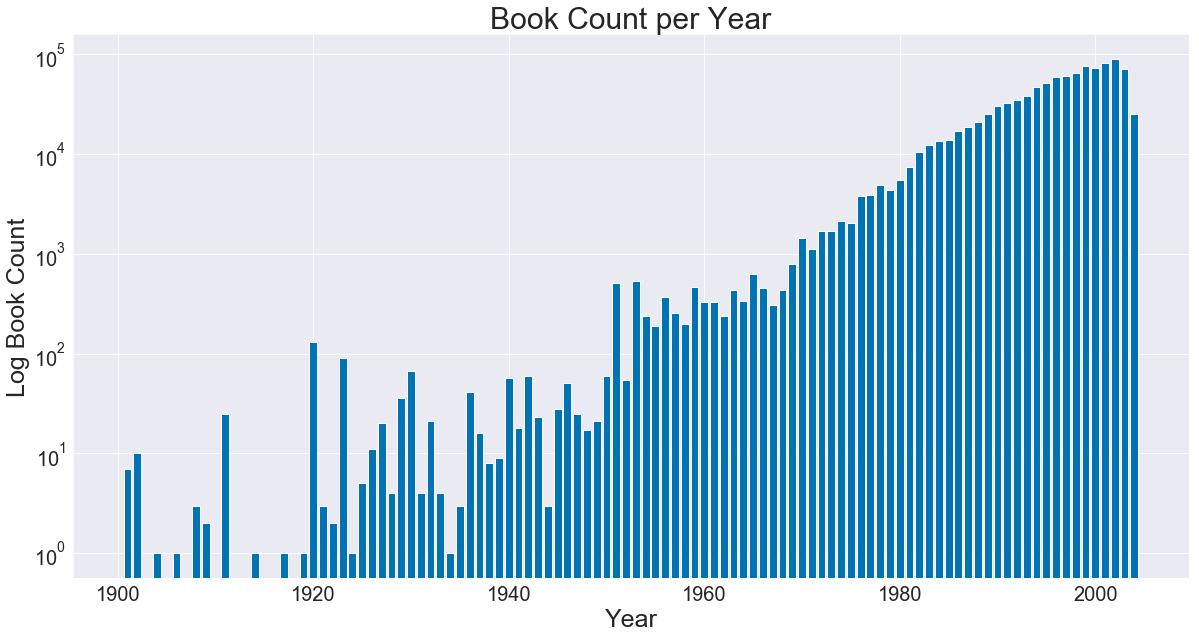

In [229]:
plt.figure(figsize=(20, 10))
plt.bar(x=ratings_and_books['year_of_publication'][
                    (ratings_and_books['year_of_publication'] > 1900) & 
                    (ratings_and_books['year_of_publication'] < 2005)].value_counts().index,
        height=ratings_and_books['year_of_publication'][
                    (ratings_and_books['year_of_publication'] > 1900) & 
                    (ratings_and_books['year_of_publication'] < 2005)].value_counts().values,
        log=True)
plt.title('Book Count per Year', fontsize=30)
plt.xlabel('Year', fontsize=25)
plt.ylabel('Log Book Count', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

### ISBN

In [194]:
ratings_and_books['isbn'].nunique()

250105

Replace ASIN (amazon standard identification numbers)

In [195]:
good_isbns = ratings_and_books['isbn'].map(lambda x: x if re.findall('^[\dXx]+$', x) else None)

In [196]:
no_replacement_isbns = []
for i in good_isbns[good_isbns.isna()].index:
    bad_isbn = ratings_and_books.loc[i, 'isbn']
    title_author = books_df[books_df['isbn'] == bad_isbn][['book_title', 'book_author']].values[0]
    try:
        new_isbn = books_df[(books_df['book_title'] == title_author[0]) & 
                            (books_df['book_author'] == title_author[1]) & 
                            (books_df['isbn'] != bad_isbn)]['isbn'].values[0]
        ratings_and_books.loc[i, 'isbn'] = new_isbn
    except:
        no_replacement_isbns.append(i)

In [200]:
len(no_replacement_isbns)

65

In [203]:
ratings_and_books.loc[no_replacement_isbns[:5]]

,isbn,book_title,book_author,year_of_publication,publisher,user_id,book_rating
299148,B0000633PU,The Story of Aladdin and the Wonderful Lamp,S. Lane Poole,0,Renaissance eBooks,10118,8
299149,B0000633PU,The Story of Aladdin and the Wonderful Lamp,S. Lane Poole,0,Renaissance eBooks,16359,8
299150,B0000633PU,The Story of Aladdin and the Wonderful Lamp,S. Lane Poole,0,Renaissance eBooks,262186,0
333174,B00007FYKO,Bloodcurdling Tales of Horror and the Macabre:...,H. P. Lovecraft,0,Ballantine,13093,0
359387,B0000DAPP1,Discover Your Genius: How to Think Like Histor...,Michael J. Gelb,2002,HarperCollins,1903,5


### Users

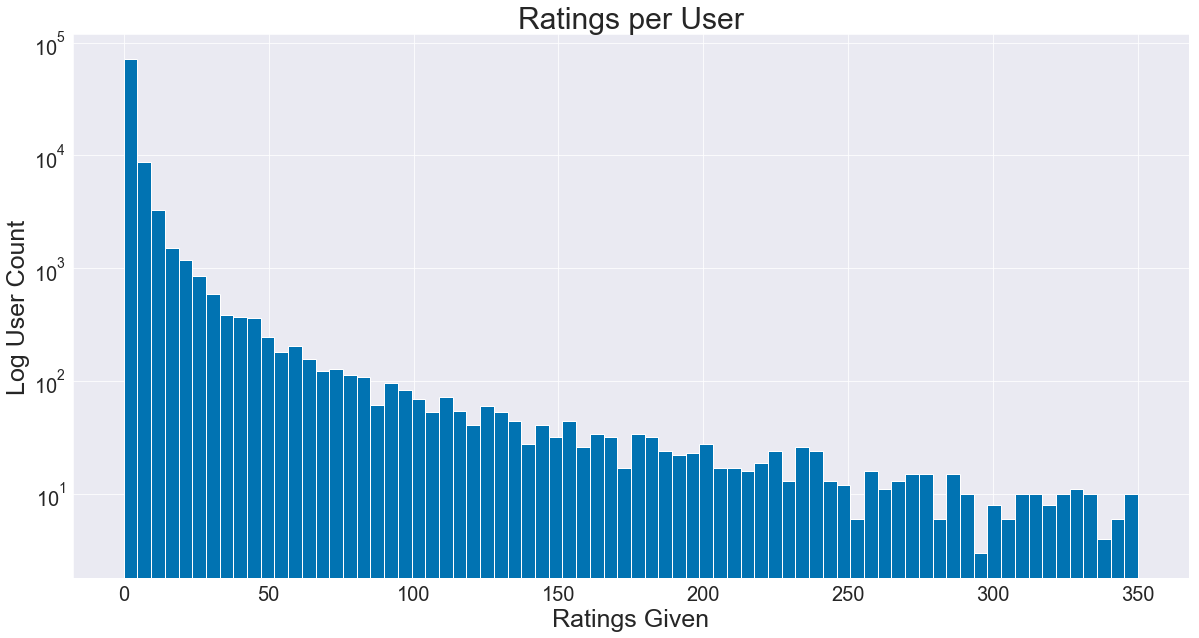

In [38]:
plt.figure(figsize=(20, 10))
plt.hist(x=ratings_and_books['user_id'].value_counts().values,
         bins=np.linspace(0, 350, 75)) 
plt.gca().set_yscale("log")
plt.title('Ratings per User', fontsize=30)
plt.xlabel('Ratings Given', fontsize=25)
plt.ylabel('Log User Count', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

### Ratings

In [235]:
ratings_and_books['book_rating'].value_counts().sort_index()

0     647323
1       1481
2       2375
3       5118
4       7617
5      45355
6      31689
7      66404
8      91806
9      60780
10     71227
Name: book_rating, dtype: int64

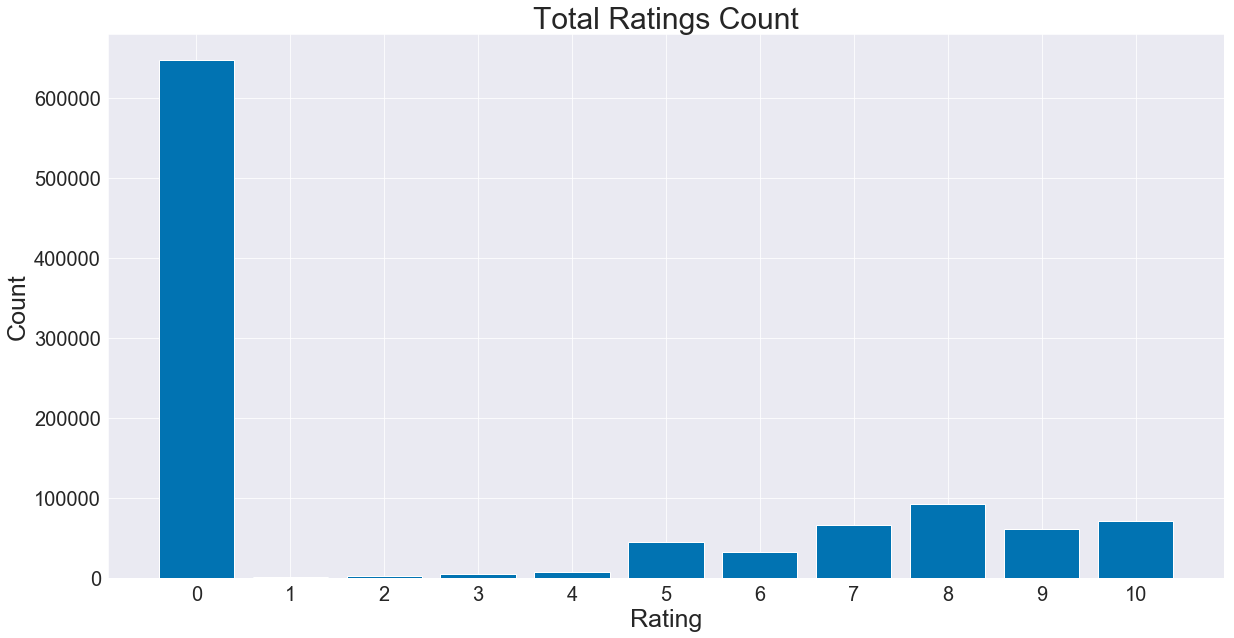

In [40]:
plt.figure(figsize=(20, 10))
plt.bar(x=ratings_and_books['book_rating'].value_counts().index,
        height=ratings_and_books['book_rating'].value_counts().values)
plt.title('Total Ratings Count', fontsize=30)
plt.xlabel('Rating', fontsize=25)
plt.ylabel('Count', fontsize=25)
plt.xticks(ratings_df['book_rating'].value_counts().index, fontsize=20)
plt.yticks(fontsize=20);

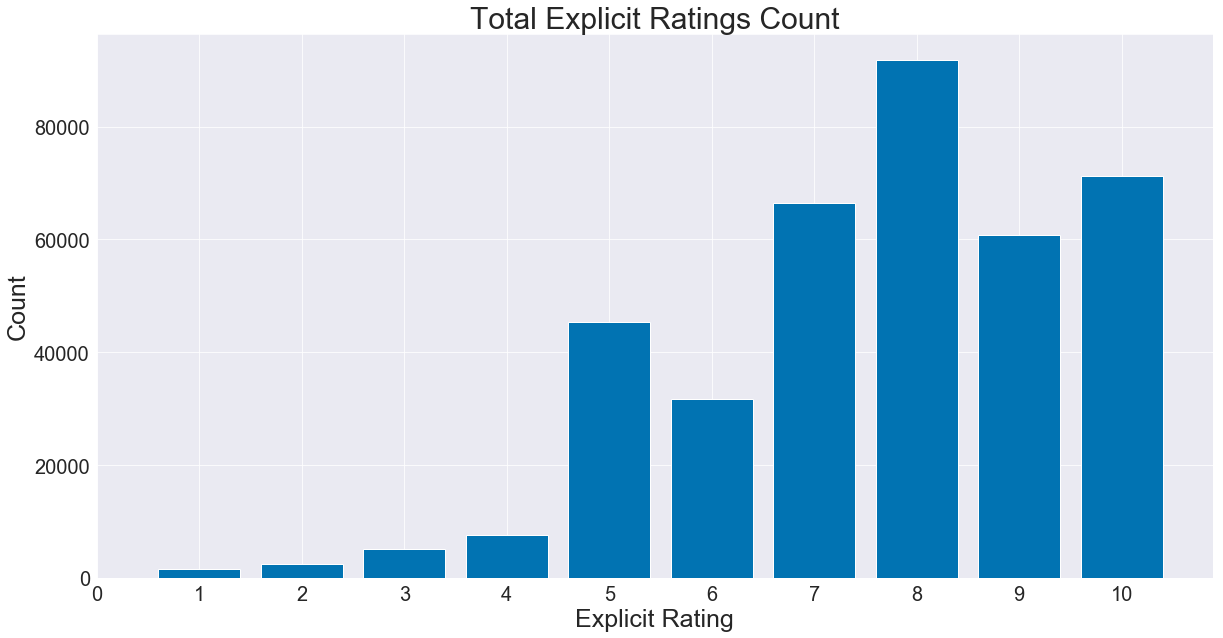

In [41]:
plt.figure(figsize=(20, 10))
plt.bar(x=ratings_and_books['book_rating'].value_counts().index[1:],
        height=ratings_and_books['book_rating'].value_counts().values[1:])
plt.title('Total Explicit Ratings Count', fontsize=30)
plt.xlabel('Explicit Rating', fontsize=25)
plt.ylabel('Count', fontsize=25)
plt.xticks(ratings_df['book_rating'].value_counts().index, fontsize=20)
plt.yticks(fontsize=20);

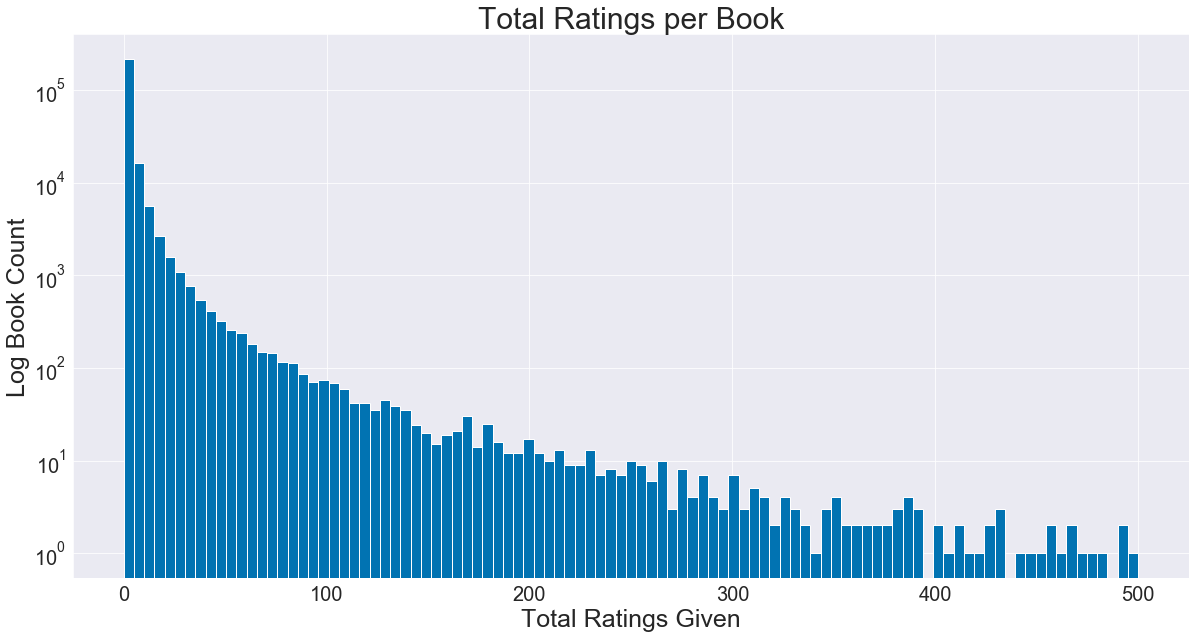

In [43]:
plt.figure(figsize=(20, 10))
plt.hist(x=ratings_and_books['isbn'].value_counts().values,
         bins=np.linspace(0,500,100))
plt.gca().set_yscale("log")
plt.title('Total Ratings per Book', fontsize=30)
plt.xlabel('Total Ratings Given', fontsize=25)
plt.ylabel('Log Book Count', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

In [ ]:
ratings_and_books.to_csv('../data/cleaned_ratings_and_books.csv')

## Explicit and Implicit Ratings

In [44]:
exp_ratings = ratings_and_books[ratings_and_books['book_rating'] != 0] 

In [45]:
exp_ratings[['book_rating']].describe().T

,count,mean,std,min,25%,50%,75%,max
book_rating,383852.0,7.62671,1.841331,1.0,7.0,8.0,9.0,10.0


In [46]:
imp_ratings = ratings_and_books[ratings_and_books['book_rating'] == 0]

In [47]:
print("Explicit:", exp_ratings.shape[0])
print("Implicit:", imp_ratings.shape[0])

Explicit: 383852
Implicit: 647323


In [49]:
imp_count = imp_ratings.groupby(
    ['isbn', 'book_title'], as_index=False)[['book_rating']].count().rename(
    columns={'book_rating': 'implicit_count'})

exp_count = exp_ratings.groupby(
    ['isbn', 'book_title'], as_index=False)[['book_rating']].count().rename(
    columns={'book_rating': 'explicit_count'})

In [50]:
ratings_count = imp_count.merge(exp_count.drop(columns='book_title'), 
                                how='outer', 
                                on='isbn').fillna(0).astype({'implicit_count': int, 'explicit_count': int})

In [51]:
ratings_count['total_count'] = ratings_count['implicit_count'] + ratings_count['explicit_count']

In [52]:
ratings_count.sort_values(by='total_count', ascending=False).head(10)

,isbn,book_title,implicit_count,explicit_count,total_count
153872,0971880107,Wild Animus,1921,581,2502
26540,0316666343,The Lovely Bones: A Novel,588,707,1295
52553,0385504209,The Da Vinci Code,399,488,887
22917,0312278586,The Nanny Diaries: A Novel,435,393,828
12646,014028009X,Bridget Jones's Diary,438,377,815
152997,096533192X,The Secret Life of Bees,368,406,774
4922,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,417,323,740
22288,0312195516,The Red Tent (Bestselling Backlist),340,383,723
97660,0671027352,Angels Demons,360,310,670
16072,0156027321,Life of Pi,328,336,664


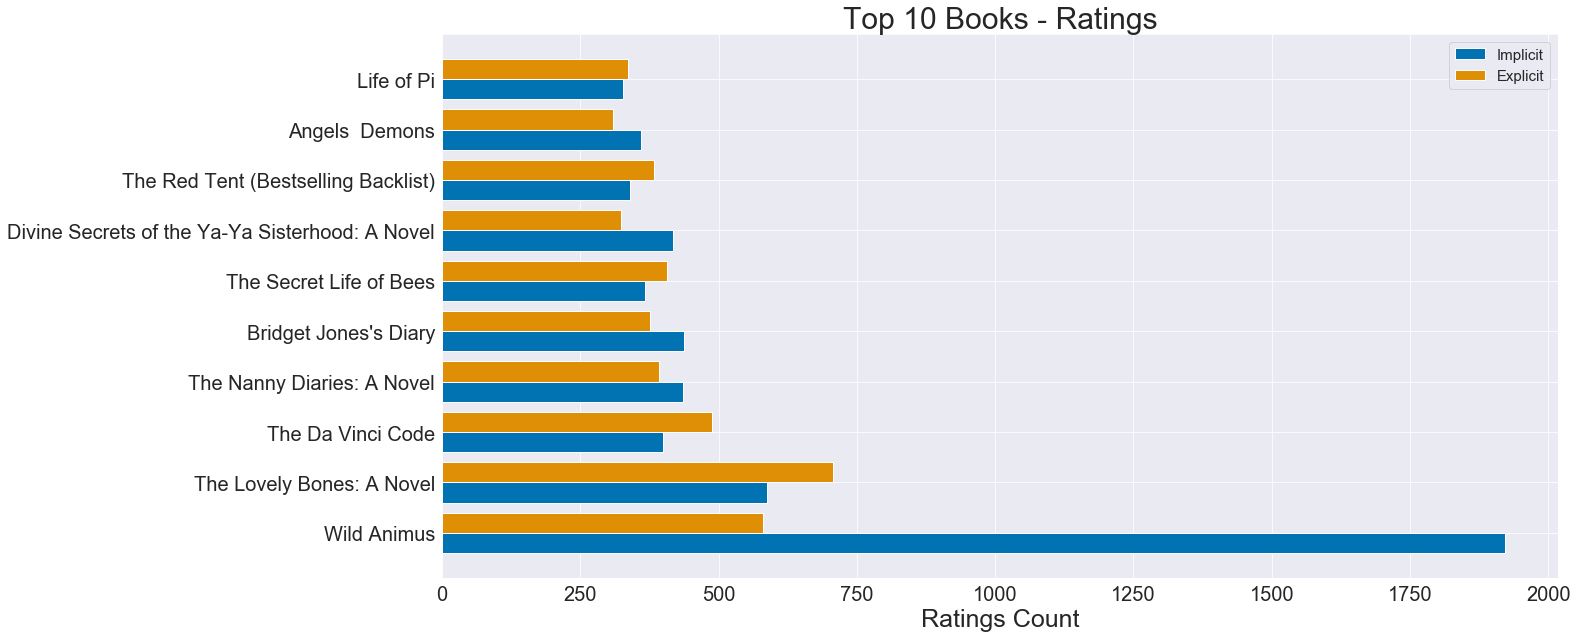

In [53]:
plt.figure(figsize=(20, 10))
plt.barh(y=ratings_count.sort_values(by='total_count', ascending=False)['book_title'].head(10),
         width=ratings_count.sort_values(by='total_count', ascending=False)['implicit_count'].head(10), 
         align='edge',
         height=-.4)
plt.barh(y=ratings_count.sort_values(by='total_count', ascending=False)['book_title'].head(10),
         width=ratings_count.sort_values(by='total_count', ascending=False)['explicit_count'].head(10),
         align='edge',
         height=.4)
plt.legend(['Implicit', 'Explicit'], fontsize=15)
plt.title('Top 10 Books - Ratings', fontsize=30)
plt.xlabel('Ratings Count', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

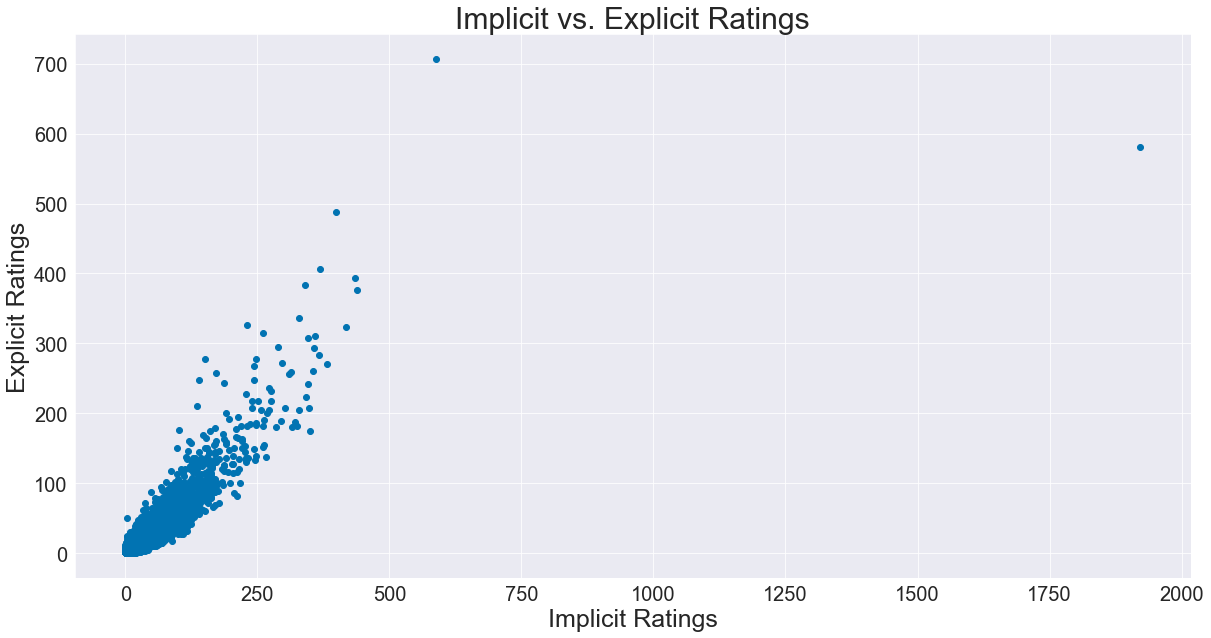

In [54]:
plt.figure(figsize=(20, 10))
plt.scatter(x=ratings_count['implicit_count'],
            y=ratings_count['explicit_count'])
plt.xlabel('Implicit Ratings', fontsize=25)
plt.ylabel('Explicit Ratings', fontsize=25)
plt.title('Implicit vs. Explicit Ratings', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

### Save As CSV

In [ ]:
exp_ratings.to_csv('../data/exp_ratings.csv')

In [ ]:
imp_ratings.to_csv('../data/imp_ratings.csv')

In [ ]:
exp_ratings.to_sql(name='exp_ratings',
                   con=engine,
                   index=False)

In [ ]:
imp_ratings.to_sql(name='exp_ratings',
                   con=engine,
                   index=False)

## Explicit Ratings Threshold

In [59]:
# isbn_greater_three = exp_ratings['isbn'].value_counts().index[exp_ratings['isbn'].value_counts().values > 3]

# new_exp_ratings = exp_ratings[exp_ratings['isbn'].isin(isbn_greater_three)]

# print('Users:  ', new_exp_ratings['user_id'].nunique())
# print('Books:  ', new_exp_ratings['isbn'].nunique())
# print('Ratings:', new_exp_ratings.shape[0])

# # new_exp_ratings.to_sql(name='exp_ratings',
# #                        con=engine,
# #                        index=False)

# # new_exp_ratings.to_csv('../data/explicit_ratings.csv')